In [2]:
import pandas as pd
import numpy as np
import warnings

from numpy.testing.overrides import allows_array_ufunc_override

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

seed = 0

In [3]:
!pip install pyscipopt seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [4]:
from math import ceil, floor
import numpy as np

class Params:
    def __init__(self, var_idx: int, x_i: float, node_depth: int, nr_variables: int, curr_obj: float,
                 n_branches_by_var: int, n_nodes: int, downfrac: float, allowed_increase: float, allowed_decrease: float,
                 upfrac: float, objective_increases: list, nr_fixed_variables: int, root_obj_val: float,
                 up_pseudo_cost: float, down_pseudo_cost: float, sense: str):
        self.var_idx = var_idx
        self.x_i = x_i
        self.node_depth = node_depth
        self.nr_variables = nr_variables
        self.nr_fixed_variables = nr_fixed_variables
        self.curr_obj = curr_obj
        self.n_branches_by_var = n_branches_by_var
        self.n_nodes = n_nodes
        self.down_frac = downfrac
        self.up_frac = upfrac
        self.allowed_decrease = allowed_decrease
        self.allowed_increase = allowed_increase
        self.objective_increases = objective_increases
        self.root_obj_val = root_obj_val
        self.up_pseudo_cost = up_pseudo_cost
        self.down_pseudo_cost = down_pseudo_cost
        self.sense = sense

def __static_feat(i: int, A: np.ndarray, b: np.ndarray, c: np.ndarray):
    features = {}
    # 1st class
    # sign{c_i}
    c_i = c[i]
    features['sign'] = np.sign(c_i)

    # |c_i| / sum_{k: c_k >= 0} |c_k|
    pos_sum = np.sum(np.abs(c[c >= 0]))
    # |c_i| / sum_{k: c_k < 0} |c_k|
    neg_sum = np.sum(np.abs(c[c < 0]))

    features['c_i/sum_pos'] = abs(c_i) / pos_sum if pos_sum != 0 else 0
    features['c_i/sum_neg'] = abs(c_i) / neg_sum if neg_sum != 0 else 0

    # 2nd class
    # m_j^{+1}(i) = A_{ji}/|b_j|, forall j s.t. b_j >= 0
    M1_pos = []
    # m_j^{-1}(i) = A_{ji}/|b_j|, forall j s.t. b_j < 0
    M1_neg = []
    for j in range(A.shape[0]):
        a_ji = A[j, i]
        if b[j] >= 0:
            M1_pos.append(a_ji / abs(b[j]) if b[j] != 0 else 0)
        else:
            M1_neg.append(a_ji / abs(b[j]))

    features['M1_pos_min'] = np.min(M1_pos) if M1_pos else 0
    features['M1_pos_max'] = np.max(M1_pos) if M1_pos else 0
    features['M1_neg_min'] = np.min(M1_neg) if M1_neg else 0
    features['M1_neg_max'] = np.max(M1_neg) if M1_neg else 0

    # m_j^{2+} (i) = |c_i|/|A_{ji}| forall j s.t. c_i >= 0
    M2_pos = []
    # m_j^{2-} (i) = |c_i|/|A_{ji}| forall j s.t. c_i < 0
    M2_neg = []
    for j in range(A.shape[0]):
        if c[i] >= 0:
            M2_pos.append(abs(c_i) / abs(A[j, i]) if A[j, i] != 0 else 0)
        else:
            M2_neg.append(abs(c_i) / abs(A[j, i]) if A[j, i] != 0 else 0)

    features['M2_pos_min'] = np.min(M2_pos) if M2_pos else 0
    features['M2_pos_max'] = np.max(M2_pos) if M2_pos else 0
    features['M2_neg_min'] = np.min(M2_neg) if M2_neg else 0
    features['M2_neg_max'] = np.max(M2_neg) if M2_neg else 0

    M3_pp = []
    M3_pm = []
    M3_mp = []
    M3_mm = []

    for j in range(A.shape[0]):
        pos_sum = np.sum(np.abs(A[j, A[j] >= 0]))
        neg_sum = np.sum(np.abs(A[j, A[j] < 0]))

        a_ji = abs(A[j, i])
        if A[j, i] >= 0:
            M3_pp.append(a_ji / pos_sum if pos_sum != 0 else 0)
            M3_pm.append(a_ji / neg_sum if neg_sum != 0 else 0)
        else:
            M3_mp.append(a_ji / pos_sum if pos_sum != 0 else 0)
            M3_mm.append(a_ji / neg_sum if neg_sum != 0 else 0)

    features['M3_pp_min'] = np.min(M3_pp) if M3_pp else 0
    features['M3_pp_max'] = np.max(M3_pp) if M3_pp else 0
    features['M3_pm_min'] = np.min(M3_pm) if M3_pm else 0
    features['M3_pm_max'] = np.max(M3_pm) if M3_pm else 0
    features['M3_mp_min'] = np.min(M3_mp) if M3_mp else 0
    features['M3_mp_max'] = np.max(M3_mp) if M3_mp else 0
    features['M3_mm_min'] = np.min(M3_mm) if M3_mm else 0
    features['M3_mm_max'] = np.max(M3_mm) if M3_mm else 0

    return features


def __dynamic_feat(params: Params, c: np.ndarray):
    features = {}
    features['depth'] = params.node_depth / params.nr_variables
    features['fixed_vars'] = params.nr_fixed_variables / params.nr_variables

    features['min_xi'] = min(params.x_i - floor(params.x_i), ceil(params.x_i) - params.x_i)

    # sensitivity ranges
    c_i = c[params.var_idx]
    features['sign_allowed_decrease'] = np.sign(params.allowed_decrease)
    features['sign_allowed_increase'] = np.sign(params.allowed_increase)

    normalized_decrease = (c_i - params.allowed_decrease) / np.abs(c_i)
    normalized_increase = (params.allowed_increase - c_i) / np.abs(c_i)

    # features['log_allowed_decrease'] = np.log(normalized_decrease) if normalized_decrease != 0 else 0
    # features['log_allowed_increase'] = np.log(normalized_increase) if normalized_increase != 0 else 0

    features['down_frac'] = params.down_frac
    features['up_frac'] = params.up_frac

    return features


def __dynamic_opt_feat(params: Params):
    features = {}
    features['branching_ratio'] = params.n_branches_by_var / params.n_nodes

    features['min_obj_increase'] = np.min(params.objective_increases) if params.objective_increases else 0
    features['max_obj_increase'] = np.max(params.objective_increases) if params.objective_increases else 0
    features['avg_obj_increase'] = np.mean(params.objective_increases) if params.objective_increases else 0
    features['std_obj_increase'] = np.std(params.objective_increases) if params.objective_increases else 0

    # quartiles
    features['quartile_25_obj_increase'] = np.percentile(params.objective_increases, 25) if params.objective_increases else 0
    features['quartile_50_obj_increase'] = np.percentile(params.objective_increases, 50) if params.objective_increases else 0
    features['quartile_75_obj_increase'] = np.percentile(params.objective_increases, 75) if params.objective_increases else 0

    # divide all by curr_obj
    features['min_obj_increase'] /= params.curr_obj if params.curr_obj != 0 else 0
    features['max_obj_increase'] /= params.curr_obj if params.curr_obj != 0 else 0
    features['avg_obj_increase'] /= params.curr_obj if params.curr_obj != 0 else 0
    features['std_obj_increase'] /= params.curr_obj if params.curr_obj != 0 else 0
    features['quartile_25_obj_increase'] /= params.curr_obj if params.curr_obj != 0 else 0
    features['quartile_50_obj_increase'] /= params.curr_obj if params.curr_obj != 0 else 0
    features['quartile_75_obj_increase'] /= params.curr_obj if params.curr_obj != 0 else 0

    # pseudocosts
    features['up_pseudocost'] = params.up_pseudo_cost / params.root_obj_val
    features['down_pseudocost'] = params.down_pseudo_cost / params.root_obj_val
    return features


def compute_features(params: Params, A: np.ndarray, b: np.ndarray, c: np.ndarray):
    static = __static_feat(params.var_idx, A, b, c)
    dynamic = __dynamic_feat(params, c)
    dynamic_opt = __dynamic_opt_feat(params)

    return {**static, **dynamic, **dynamic_opt}


In [5]:
from pyscipopt import Model, Branchrule, Variable
from pyscipopt import SCIP_RESULT
import numpy as np
from collections import defaultdict
import pandas as pd

class StrongBranchingRule(Branchrule):
    def __init__(self, model, A, b, c, logged, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model: Model = model
        self.dataset = pd.DataFrame()
        self.A = A
        self.b = b
        self.c = c
        self.logged = logged
        self.n_branches_by_var = defaultdict(int)
        self.objective_increases_by_var = defaultdict(list)
        self.down_pseudo_costs_history = defaultdict(float)
        self.up_pseudo_costs_history = defaultdict(float)
        self.root_obj_val = model.infinity() if model.getObjectiveSense() == "minimize" else -model.infinity()

    def branchexeclp(self, allowaddcons):
        branch_cands, branch_cand_sols, branch_cand_fracs, ncands, npriocands, nimplcands = self.model.getLPBranchCands()

        # Initialise scores for each variable
        scores = [-self.model.infinity() for _ in range(npriocands)]
        down_bounds = [None for _ in range(npriocands)]
        up_bounds = [None for _ in range(npriocands)]

        # Initialise placeholder values
        num_nodes = self.model.getNNodes()
        lpobjval = self.model.getLPObjVal()
        lperror = False
        best_cand_idx = 0
        best_cand_gain = 0

        # Start strong branching and iterate over the branching candidates
        self.model.startStrongbranch()
        for i in range(npriocands):

            # Check the case that the variable has already been strong branched on at this node.
            # This case occurs when events happen in the node that should be handled immediately.
            # When processing the node again (because the event did not remove it), there's no need to duplicate work.
            if self.model.getVarStrongbranchNode(branch_cands[i]) == num_nodes:
                down, up, downvalid, upvalid, _, lastlpobjval = self.model.getVarStrongbranchLast(branch_cands[i])
                if downvalid:
                    down_bounds[i] = down
                if upvalid:
                    up_bounds[i] = up
                downgain = max([down - lastlpobjval, 0])
                upgain = max([up - lastlpobjval, 0])
                scores[i] = self.model.getBranchScoreMultiple(branch_cands[i], [downgain, upgain])
                continue

            # Strong branch
            down, up, downvalid, upvalid, downinf, upinf, downconflict, upconflict, lperror = self.model.getVarStrongbranch(
                branch_cands[i], 200, idempotent=False)

            # In the case of an LP error handle appropriately (for this example we just break the loop)
            if lperror:
                break

            # In the case of both infeasible sub-problems cutoff the node
            if downinf and upinf:
                return {"result": SCIP_RESULT.CUTOFF}

            # Calculate the gains for each up and down node that strong branching explored
            if not downinf and downvalid:
                down_bounds[i] = down
                downgain = max([down - lpobjval, 0])
            else:
                downgain = 0
            if not upinf and upvalid:
                up_bounds[i] = up
                upgain = max([up - lpobjval, 0])
            else:
                upgain = 0


            # Update the pseudo-costs
            lpsol = branch_cands[i].getLPSol()
            if not downinf and downvalid:
                self.model.updateVarPseudocost(branch_cands[i], -self.model.frac(lpsol), downgain, 1)
                self.down_pseudo_costs_history[branch_cands[i].name] = downgain / -self.model.frac(lpsol)
                self.objective_increases_by_var[branch_cands[i].name].append(downgain)
            if not upinf and upvalid:
                self.model.updateVarPseudocost(branch_cands[i], 1 - self.model.frac(lpsol), upgain, 1)
                self.up_pseudo_costs_history[branch_cands[i].name] = upgain / (1 - self.model.frac(lpsol))
                self.objective_increases_by_var[branch_cands[i].name].append(upgain)

            scores[i] = self.model.getBranchScoreMultiple(branch_cands[i], [downgain, upgain])

            if scores[i] > scores[best_cand_idx]:
                best_cand_idx = i

            self.n_branches_by_var[branch_cands[i].name] += 1
            features = self.extract_feats(branch_cand_fracs[i], branch_cands[i])
            curr_obj = self.model.getLPObjVal()
            features['score'] = scores[i] / np.abs(curr_obj) if curr_obj != 0 else 0
            row = pd.DataFrame.from_dict(features, orient='index').T
            self.dataset = pd.concat([self.dataset, row], ignore_index=True)

        # End strong branching
        self.model.endStrongbranch()

        # In the case of an LP error
        if lperror:
            return {"result": SCIP_RESULT.DIDNOTRUN}

        var_name = branch_cands[best_cand_idx].name

        # print("--> Strong branching on variable:", branch_cands[best_cand_idx].name)
        # Branch on the variable with the largest score
        down_child, eq_child, up_child = self.model.branchVarVal(
            branch_cands[best_cand_idx], branch_cands[best_cand_idx].getLPSol())

        # Update the bounds of the down node and up node. Some cols might not exist due to pricing
        if self.model.allColsInLP():
            if down_child is not None and down_bounds[best_cand_idx] is not None:
                self.model.updateNodeLowerbound(down_child, down_bounds[best_cand_idx])
            if up_child is not None and up_bounds[best_cand_idx] is not None:
                self.model.updateNodeLowerbound(up_child, up_bounds[best_cand_idx])

        return {"result": SCIP_RESULT.BRANCHED}

    def compute_obj_coeff_sensitivity(self, var):
      return 0, 0
      EPS = self.model.getParam("numerics/feastol") # Get numerical tolerance from SCIP

      # non basic variables
      if abs(self.model.getVal(var)) < EPS:
          red_cost = self.model.getVarRedcost(var)
          if red_cost < 0: # Should not happen for optimal non-basic in maximization
              allowable_increase = abs(red_cost) # If original reduced cost was negative, it means its coefficient should decrease.
              allowable_decrease = float('inf')
          else:
              allowable_increase = red_cost
              allowable_decrease = float('inf')
          return allowable_increase, allowable_decrease

      else: # If variable is basic (value is non-zero)
          current_obj_coeff = var.getObj()

          # Get LP column for the variable being analyzed
          var_col = var.getCol()
          if var_col is None:
              return float('inf'), float('inf')

          lp_basis_cols_indices = self.model.getLPBasisInd()
          lp_cols_data = self.model.getLPColsData()

          basic_var_lp_row_idx = -1
          for i, col_idx in enumerate(lp_basis_cols_indices):
              if lp_cols_data[col_idx].getVar().name == var.name:
                  basic_var_lp_row_idx = i
                  break

          if basic_var_lp_row_idx == -1:
              return float('inf'), float('inf')

          b_inv_a_row_coeffs = self.model.getLPBInvARow(basic_var_lp_row_idx)

          min_ratio_for_increase = float('inf')  # For Delta_c_k > 0
          max_ratio_for_decrease = -float('inf') # For Delta_c_k < 0

          # Iterate over all non-basic variables
          for var in self.model.getVars():
              if abs(self.model.getVal(var)) < EPS: # If `var` is non-basic
                  # non_basic_col = var.getCol()
                  # if non_basic_col is None:
                  #     continue # Skip if not an LP column

                  red_cost = self.model.getVarRedcost(var)

                  # Get the corresponding coefficient (a_bar_kj) from the B_inv_A row
                  a_bar_kj = b_inv_a_row_coeffs.get(non_basic_col, 0.0)

                  if a_bar_kj > EPS: # a_bar_kj > 0
                      ratio = red_cost / a_bar_kj
                      min_ratio_for_increase = min(min_ratio_for_increase, ratio)
                  elif a_bar_kj < -EPS: # a_bar_kj < 0
                      ratio = red_cost / a_bar_kj # This ratio will be negative
                      max_ratio_for_decrease = max(max_ratio_for_decrease, ratio)

          allowable_increase = min_ratio_for_increase if min_ratio_for_increase != float('inf') else float('inf')
          allowable_decrease = -max_ratio_for_decrease if max_ratio_for_decrease != -float('inf') else float('inf')

          return allowable_increase, allowable_decrease


    def n_fixed_vars(self):
      # from: https://github.com/scipopt/PySCIPOpt/issues/347#issuecomment-602466658
      fixedvars = 0
      transvars = self.model.getVars(transformed = True)
      for var in transvars:
          if self.model.isFeasEQ(var.getLbLocal(), var.getUbLocal()):
              fixedvars+=1
      return fixedvars

    def extract_feats(self, frac, var):
      allowable_increase, allowable_decrease = self.compute_obj_coeff_sensitivity(var)
      params = Params(
          var_idx=var.getCol().getLPPos(),
          x_i=var.getObj(),
          node_depth=self.model.getCurrentNode().getDepth(),
          nr_variables=self.model.getNVars(),
          curr_obj=self.model.getLPObjVal(),
          n_branches_by_var=self.n_branches_by_var[var.name],
          n_nodes=self.model.getNNodes(),
          downfrac=frac,
          upfrac=1 - frac,
          objective_increases=self.objective_increases_by_var[var.name],
          nr_fixed_variables=self.n_fixed_vars(),
          root_obj_val=self.model.getDualboundRoot(),
          up_pseudo_cost=np.mean(self.up_pseudo_costs_history[var.name]),
          down_pseudo_cost=np.mean(self.down_pseudo_costs_history[var.name]),
          allowed_decrease=allowable_decrease,
          allowed_increase=allowable_increase,
          sense=self.model.getObjectiveSense()
      )
      return compute_features(params, self.A, self.b, self.c)


In [6]:
from collections import defaultdict
from datetime import datetime
import numpy as np
from pyscipopt import Model, quicksum, SCIP_PARAMSETTING
from pyscipopt import Branchrule
from pyscipopt.scip import Term
from pyscipopt.scip import Solution

class Problem:
    def __init__(self, name, c, lb, ub, constraint_types, b, A, var_types=None, model=None):
        self.name = name
        self.c = c
        self.lb = lb
        self.ub = ub
        self.constraint_types = constraint_types
        self.var_types = var_types if var_types is not None else ['B'] * len(c)  # assuming binary
        self.b = b
        self.A = A

        self.model = model

    @staticmethod
    def from_model(path):
        model = Model()
        model.readProblem(path)
        name = model.getProbName()

        variables = model.getVars()
        constraints = model.getConss()

        # Initialize data structures
        n_vars = len(variables)
        n_cons = len(constraints)

        # Create mapping from variable to index
        A_data = defaultdict(float)
        b = np.zeros(n_cons)
        c = np.zeros(n_vars)

        # Extract objective coefficients (vector c)
        for i, var in enumerate(variables):
            c[i] = model.getObjective().terms.get(Term(var), 0.0)

        variables = model.getVars()
        var_names = [v.name for v in variables]
        num_vars = len(variables)

        # Initialize A and b
        A = []
        b = []
        constraint_senses = []

        all_constraints = model.getConss()

        for con in all_constraints:
            assert con.isLinear(), "Only linear constraints are supported"

            # Get coefficients for this linear constraint
            coeffs = model.getValsLinear(con)

            # Create a row for the A matrix
            row = [0.0] * num_vars
            for var, coeff in coeffs.items():
                v = list(filter(lambda x: x.name == var, model.getVars()))[0]
                try:
                    # Find the index of the variable in our ordered list
                    var_index = v.getIndex()
                    row[var_index] = coeff
                except ValueError:
                    # This case should ideally not happen if getVars() gets all relevant variables,
                    # but it's good practice to handle unexpected variables.
                    print(
                        f"Warning: Variable {var.getName()} found in constraint {con.getName()} but not in model's getVars() list.")
                    pass

            rhs = model.getRhs(con)
            A.append(row)
            b.append(rhs)

        A = np.array(A)
        b = np.array(b)
        return Problem(name, c=c, lb=[], ub=[], constraint_types=[], b=b, A=A, var_types=[], model=model)

    def solve_with_sb(self, logged=False):
        self.model = self.__build_model() if self.model is None else self.model
        self.basic_config(logged=logged)
        self.disable_configs()

        sb = StrongBranchingRule(self.model, self.A, self.b, self.c, logged)
        self.model.includeBranchrule(
            sb,
            "customstrbrnch",
            "Custom strong branching rule for learning",
            priority=1000000,  # High priority to ensure it's used
            maxdepth=-1,  # No depth limit
            maxbounddist=1.0
        )
        start = datetime.now()
        self.model.optimize()
        end = datetime.now()

        assert self.model.getStatus() == "optimal", f"Model {self.model.getProbName()} did not solve to optimality. Status: {self.model.getStatus()}"

        stats = {
            'time': (end - start).total_seconds(),
            'n_vars': len(self.c),
            'n_constraints': len(self.b),
            'name': self.name,
            'sb_decision': sb.model.getNNodes(),
            'gap': sb.model.getGap(),
        }
        self.model.freeProb()
        return sb.dataset, stats

    def solve_with_learned_sb(self, predictor, logged=False, max_nodes=-1, timelimit=-1):
        model = self.__build_model() if self.model is None else self.model
        self.basic_config(logged=logged, max_nodes=max_nodes, timelimit=timelimit)
        self.disable_configs()

        sb = LearnedStrongBranching(model, predictor, self.A, self.b, self.c, logged)
        model.includeBranchrule(
            sb,
            "learnedstrongbranching",
            "Custom learned strong branching rule",
            priority=1000000,  # High priority to ensure it's used
            maxdepth=-1,
            maxbounddist=1.0
        )

        start = datetime.now()
        model.optimize()
        end = datetime.now()

        assert model.getStatus() == "optimal", f"Model {model.getProbName()} did not solve to optimality. Status: {model.getStatus()}"

        stats = {
            'time': (end - start).total_seconds(),
            'name': self.name,
            'sb_decision': sb.model.getNNodes(),
            'gap': sb.model.getGap(),
        }
        model.freeProb()
        return stats

    def solve_with_rule(self, rule: str, logged=False, max_nodes=-1, timelimit=-1):
        self.model = self.__build_model() if self.model is None else self.model
        self.basic_config(logged=logged, max_nodes=max_nodes, timelimit=timelimit)
        self.disable_configs()

        self.model.setIntParam(f'branching/{rule}/priority', 99999999)

        start = datetime.now()
        self.model.optimize()
        end = datetime.now()

        assert self.model.getStatus() == "optimal", f"Model {self.model.getProbName()} did not solve to optimality. Status: {self.model.getStatus()}"

        stats = {
            'time': (end - start).total_seconds(),
            'name': self.name,
            'sb_decision': self.model.getNNodes(),
            'gap': self.model.getGap(),
        }
        self.model.freeProb()
        return stats

    def __build_model(self, disable_cuts=True, disable_heuristics=True, disable_presolving=True):
        model = Model(self.name)
        n_vars = len(self.c)
        x = []
        for i in range(n_vars):
            if self.var_types[i] == 'B':
                x.append(model.addVar(name=f"x_{i}", vtype="B"))
            elif self.var_types[i] == 'C':
                x.append(model.addVar(name=f"x_{i}", vtype="C", lb=self.lb[i], ub=self.ub[i]))

        # Set objective function
        model.setObjective(quicksum(self.c[i] * x[i] for i in range(n_vars)), "minimize")

        n_constraints = len(self.b)
        if n_constraints != len(self.constraint_types):
            raise Exception(
                f"Number of constraints ({n_constraints}) doesn't match number of types ({len(self.constraint_types)})")

        # Add constraints
        for i in range(n_constraints):
            lhs = quicksum(self.A[i][j] * x[j] for j in range(n_vars) if self.A[i][j] != 0)

            if self.constraint_types[i] == 'E':
                model.addCons(lhs == self.b[i])
            elif self.constraint_types[i] == 'G':
                model.addCons(lhs >= self.b[i])
            elif self.constraint_types[i] == 'L':
                model.addCons(lhs <= self.b[i])


        assert (model.getNConss() == len(
            self.A)), "Number of constraints in model doesn't match number of constraints in problem"
        assert (model.getNConss() == len(
            self.b)), "Number of constraints in model doesn't match number of constraints in problem"
        assert (model.getNVars() == len(
            self.c)), "Number of variables in model doesn't match number of variables in problem"
        return model

    def basic_config(self, logged=False, max_nodes=-1, timelimit=-1):
        if self.model is None:
            raise Exception("Model is not built yet. Call __build_model() first.")

        if not logged:
            self.model.hideOutput()
            self.model.setIntParam('display/verblevel', 0)  # Quiet mode
        else:
            self.model.setIntParam('display/verblevel', 3)  # Verbose output

        if max_nodes > 0:
            self.model.setIntParam('limits/nodes', max_nodes)

        if timelimit > 0:
            self.model.setRealParam('limits/time', timelimit)

        self.model.setIntParam('display/freq', 500)  # logging frequency

    def disable_configs(self):
        self.model.setPresolve(SCIP_PARAMSETTING.OFF)
        self.model.setSeparating(SCIP_PARAMSETTING.OFF)
        self.model.setHeuristics(SCIP_PARAMSETTING.OFF)

    def __repr__(self):
        return f"Problem(name={self.name})"



In [7]:
import numpy as np

"""
Formulation
min k = sum_{j in J} y_j
s.t.
     k >= 1
     sum_{i in I} s(i) x_{ij} <= B y_i forall j in J
     sum_{j in J} x_{ij} = 1 forall i in I

     y_j in {0,1} forall j in J
     x_{ij} in {0,1} forall i in I, j in J

     x_{ij} in {0,1} forall i in I, j in J
     y_j in {0,1} forall j in J

     I: items, J: bins
     s(i): size of item i
     B: bin capacity
"""


def bin_packing(n_problems: int, items: (int, int), bins: (int, int), bin_capacity: (float, float),
                item_size: (float, float)):
    return [__generate_bp(i, items, bins, bin_capacity, item_size) for i in range(n_problems)]


def __generate_bp(id: int, items: (int, int), bins: (int, int), bin_capacity: (float, float),
                       item_size: (float, float)):
    n_items = np.random.randint(*items)
    n_bins = np.random.randint(*bins)
    bin_capacity = np.random.uniform(*bin_capacity)
    item_sizes = np.random.uniform(*item_size, size=n_items)
    n_vars = n_bins + n_items * n_bins  # y_i + x_{ij}
    assert n_vars < 1000, "Community edition has a limit of 1000 variables"

    c = np.concatenate([
        np.ones(n_bins),  # cost for bins (y_j)
        np.zeros(n_items * n_bins)  # no cost for x_{ij} (multiplying n_items * n_bins as x has 2 indexes)
    ])

    A, b, types = [], [], []

    ## constraints
    # k >= 1
    A.append(np.concatenate([np.zeros(n_bins), np.ones(n_items * n_bins)]))
    b.append(1)
    types.append('G')

    # sum(s(i) * x_ij) <= B * y_j for all j
    for j in range(n_bins):
        row = np.zeros(n_vars)
        row[j] = -bin_capacity  # coefficient for y_j
        for i in range(n_items):
            row[n_bins + i * n_bins + j] = item_sizes[i]  # coefficient for x_{ij}
        A.append(row)
        b.append(0)
        types.append('L')

    # sum(x_ij) = 1 for all i
    for i in range(n_items):
        row = np.zeros(n_vars)
        for j in range(n_bins):
            row[n_bins + i * n_bins + j] = 1  # coefficient for x_{ij}
        A.append(row)
        b.append(1)
        types.append('E')

    A = np.array(A)
    b = np.array(b)
    assert A.shape[0] == b.shape[0], "A and b must have the same number of rows"
    assert b.shape[0] <= 1000, "Community edition has a limit of 1000 constraints"

    types = np.array(types)

    return Problem(
        name=f"random_BP_{id}",
        c=c,
        lb=[0] * n_vars,
        ub=[1] * n_vars,
        constraint_types=types,
        b=b,
        A=A
    )


In [8]:
import numpy as np

"""
Formulation
min sum_{s in S} x_s
s.t. sum_{s: e in s} x_s >= 1 forall e in E
x in {0,1}^n
"""

A_DENSITY = 0.3


def set_cover(n_problems: int, universe_size_range=(50, 70)):
    return [__generate_sc(i, universe_size_range) for i in range(n_problems)]

def __generate_sc(id: int, universe_size_range):
    # universe selection
    universe_size = np.random.randint(*universe_size_range)
    universe = np.random.choice(list(range(1, 100)), size=universe_size, replace=False)

    binary_matrix = np.random.randint(0, 2, size=(len(universe), len(universe)))

    # Ensure each row and column has at least one 1 to avoid empty sets
    for i in range(binary_matrix.shape[0]):
        if np.sum(binary_matrix[i, :]) == 0:
            binary_matrix[i, np.random.randint(0, binary_matrix.shape[1])] = 1

    for j in range(binary_matrix.shape[1]):
        if np.sum(binary_matrix[:, j]) == 0:
            binary_matrix[np.random.randint(0, binary_matrix.shape[0]), j] = 1

    # mapping to universe elements
    subsets = []
    for j in range(binary_matrix.shape[1]):
        subset = []
        for i in range(binary_matrix.shape[0]):
            if binary_matrix[i, j] == 1:
                subset.append(universe[i])
        subsets.append(subset)

    # remove duplicated sets from subsets
    unique_subsets = []
    for subset in subsets:
        if subset not in unique_subsets:
            unique_subsets.append(subset)

    # shuffling within subsets
    for i in range(len(unique_subsets)):
        np.random.shuffle(unique_subsets[i])

    # Create Problem object
    n_subsets = len(unique_subsets)
    n_elements = len(universe)

    A = np.zeros((n_elements, len(unique_subsets)))
    for j, subset in enumerate(unique_subsets):
        for elem in subset:
            i, = np.where(universe == elem)
            A[i, j] = 1

    c = np.ones(len(unique_subsets))
    b = np.ones(n_elements)
    types = ['G'] * n_elements

    return Problem(
        name=f"SC_{id}",
        c=c,
        lb=[0] * n_subsets,
        ub=[1] * n_subsets,
        constraint_types=types,
        b=b,
        A=A,
    )


In [9]:
from tqdm import tqdm
bp_instances, sc_instances = 0, 1

np.random.seed(seed)

generated = {}

generated['BP'] = bin_packing(
    n_problems=bp_instances,
    items=(10, 20),
    bins=(5, 10),
    bin_capacity=(0.5, 1.5),
    item_size=(0.1, 0.9),
)

generated['SC'] = set_cover(
    n_problems=sc_instances,
    universe_size_range=(80, 100),
)

In [10]:
import os

def solve(problems, name, export_dir):
    if len(problems) == 0:
        return

    dataset_name = f"{export_dir}/{name}_solution.csv"
    stats_name = f"{export_dir}/{name}_stats.csv"

    dataset = pd.read_csv(dataset_name) if os.path.exists(dataset_name) else pd.DataFrame()
    stats = pd.read_csv(stats_name) if os.path.exists(stats_name) else pd.DataFrame()

    for problem in tqdm(problems, desc=f"Solving problems {name}", unit="problem"):
        try:
            names = stats['name'].values if stats.get('name', None) is not None else []
            if not problem.name in names:
                solution, stats_result = problem.solve_with_sb(logged=False)
                dataset = pd.concat([dataset, solution], ignore_index=True)
                stats_row = pd.DataFrame.from_dict(stats_result, orient='index').T
                stats = pd.concat([stats, stats_row], ignore_index=True)
                print(f"Problem {problem.name} solved in {stats_result['time']} seconds")
                # overwrite dataset and stats files
                dataset.to_csv(f"{export_dir}/{name}_solution.csv")
                stats.to_csv(f"{export_dir}/{name}_stats.csv")
            else:
                print(f"Problem {problem.name} already solved, skipping.")
        except AssertionError as e:
            print(f"Problem has no solution: {problem.name}")
        except Exception as e:
            print(f"Error solving problem {problem.name}: {e}")
            continue



In [11]:
import os

files = os.listdir("sources/randomSC")[:10]
probs = [Problem.from_model(f"sources/randomSC/{f}") for f in files if f.endswith(".lp")]
current_dir = os.getcwd()
solve(probs, "randomSC", "output/")


original problem has 97 variables (97 bin, 0 int, 0 impl, 0 cont) and 97 constraints
original problem has 91 variables (91 bin, 0 int, 0 impl, 0 cont) and 91 constraints
original problem has 81 variables (81 bin, 0 int, 0 impl, 0 cont) and 81 constraints
original problem has 94 variables (94 bin, 0 int, 0 impl, 0 cont) and 94 constraints
original problem has 90 variables (90 bin, 0 int, 0 impl, 0 cont) and 90 constraints
original problem has 82 variables (82 bin, 0 int, 0 impl, 0 cont) and 82 constraints
original problem has 80 variables (80 bin, 0 int, 0 impl, 0 cont) and 80 constraints
original problem has 92 variables (92 bin, 0 int, 0 impl, 0 cont) and 92 constraints


Solving problems randomSC:  12%|█▎        | 1/8 [00:12<01:27, 12.50s/problem]

Problem /home/elena/Documents/projects/bnb-branching-strategy-learning/sources/randomSC/SC_23.lp solved in 12.449998 seconds
Exporting dataset and stats to output/


Solving problems randomSC:  25%|██▌       | 2/8 [00:18<00:50,  8.47s/problem]

Problem /home/elena/Documents/projects/bnb-branching-strategy-learning/sources/randomSC/SC_12.lp solved in 5.579587 seconds
Exporting dataset and stats to output/


Solving problems randomSC:  38%|███▊      | 3/8 [00:21<00:31,  6.35s/problem]

Problem /home/elena/Documents/projects/bnb-branching-strategy-learning/sources/randomSC/SC_44.lp solved in 3.709482 seconds
Exporting dataset and stats to output/


Solving problems randomSC:  50%|█████     | 4/8 [00:29<00:27,  6.78s/problem]

Problem /home/elena/Documents/projects/bnb-branching-strategy-learning/sources/randomSC/SC_22.lp solved in 7.309724 seconds
Exporting dataset and stats to output/


Solving problems randomSC:  62%|██████▎   | 5/8 [00:36<00:20,  6.86s/problem]

Problem /home/elena/Documents/projects/bnb-branching-strategy-learning/sources/randomSC/SC_33.lp solved in 6.84477 seconds
Exporting dataset and stats to output/


Solving problems randomSC:  75%|███████▌  | 6/8 [00:41<00:12,  6.10s/problem]

Problem /home/elena/Documents/projects/bnb-branching-strategy-learning/sources/randomSC/SC_92.lp solved in 4.434673 seconds
Exporting dataset and stats to output/


Solving problems randomSC:  88%|████████▊ | 7/8 [00:41<00:04,  4.29s/problem]

Problem /home/elena/Documents/projects/bnb-branching-strategy-learning/sources/randomSC/SC_34.lp solved in 0.373756 seconds
Exporting dataset and stats to output/


Solving problems randomSC: 100%|██████████| 8/8 [00:52<00:00,  6.53s/problem]

Problem /home/elena/Documents/projects/bnb-branching-strategy-learning/sources/randomSC/SC_81.lp solved in 10.422762 seconds
Exporting dataset and stats to output/


In [ ]:
import kagglehub, os

binpacking_setcover_path = kagglehub.dataset_download('elenaferr0/binpacking-setcover')
dataset_files = [
    f"{binpacking_setcover_path}/BP_train_solution.csv",
    f"{binpacking_setcover_path}/BP_test_solution.csv",
    f"{binpacking_setcover_path}/SC_train_solution.csv",
    f"{binpacking_setcover_path}/SC_test_solution.csv"
]

all_generated = True # skip problem resolution if files exist
for f in dataset_files:
    if not os.path.isfile(f):
        all_generated = False

if not all_generated:
    for name, problems in generated.items():
        print(f"Solving {name} problems")
        solve(problems['train'], f"{name}_train")
        print(f"Solving {name} test problems")
        solve(problems['test'], f"{name}_test")

/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset loading (read generated csv files)

In [ ]:
[Problem.from_model(f"sources/randomSC/{f}") for f in files if f.endswith(".lp")]

In [12]:
import pandas as pd

# all files ending by "lp_solution.csv"
train = pd.read_csv("output/randomSC_solution.csv")

# BP_train = pd.read_csv(f"{binpacking_setcover_path}/BP_train_solution.csv")
# BP_test = pd.read_csv(f"{binpacking_setcover_path}/BP_test_solution.csv")
# SC_train = pd.read_csv(f"{binpacking_setcover_path}/SC_train_solution.csv")
# SC_test = pd.read_csv(f"{binpacking_setcover_path}/SC_test_solution.csv")

# train = pd.concat([BP_train, SC_train], ignore_index=True)
# train = train.sample(frac=0.2, random_state=seed)
# test = pd.concat([BP_test, SC_test], ignore_index=True)
# test = test.sample(frac=0.2, random_state=seed)
# print(f"Train set size: {train.shape}")
# print(f"Test set size: {test.shape}")
#
X_train = train.drop(columns=['score'])
y_train = np.log(train['score'])

# X_test = test.drop(columns=['score'])
# y_test = np.log(test['score'])

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler

def create_pipeline(regressor, additional_pre_steps=[]):
  return Pipeline(steps=[
    *additional_pre_steps,
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_regression, k=10)),
    ('predictor', regressor)
  ])

## Preprocessing

### PCA

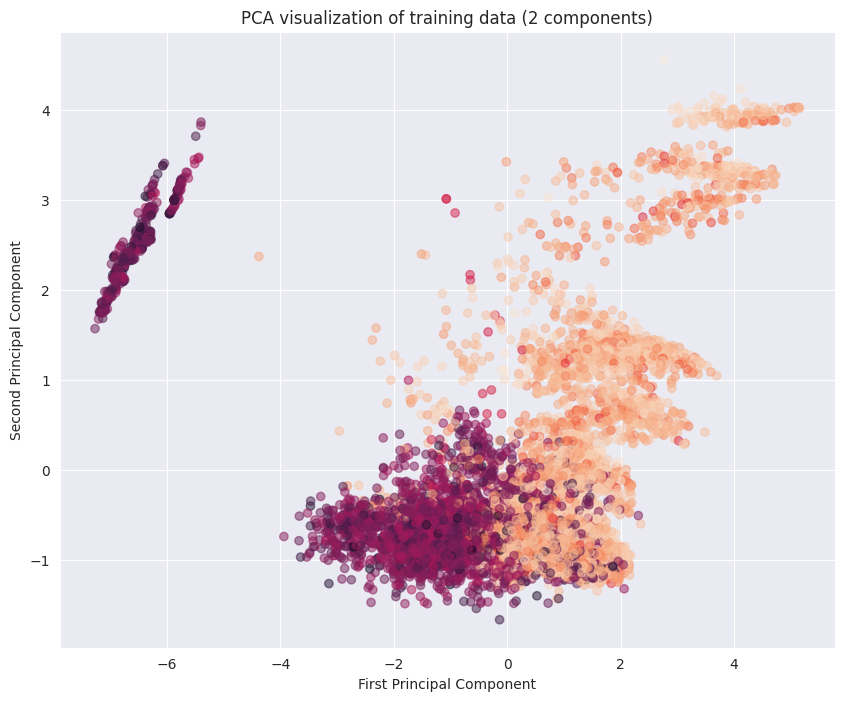

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# First PCA visualization
pipeline = create_pipeline(PCA(n_components=2))
X_pca = pipeline.fit_transform(X_train, y_train)

plt.figure(figsize=(10, 8))
plt.title('PCA visualization of training data (2 components)')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

In [ ]:
!pip install pymoo

In [15]:
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

def find_minimization_pareto_front(df, x_col, y_col):
  costs = np.column_stack([df[x_col], df[y_col]])
  nds = NonDominatedSorting()
  front = nds.do(costs, only_non_dominated_front=True)
  pareto_front_idx = np.zeros(len(costs), dtype=bool)
  pareto_front_idx[front] = True
  return pareto_front_idx

def regr_refit_strategy(cv_results):
  results_df = pd.DataFrame(cv_results)
  results_df = label_results(results_df)

  results_df['pos_mse'] = results_df['mean_test_neg_mean_squared_error'].abs()

  # find the pareto front (best tradeoffs)
  pareto_front_indexes = find_minimization_pareto_front(results_df, 'mean_score_time', 'pos_mse')

  # find the one nearest to x = y
  pareto_df = results_df.loc[pareto_front_indexes].copy()
  pareto_df.loc[:, 'distance'] = np.abs(pareto_df['mean_score_time'] - pareto_df['pos_mse']) / np.sqrt(2)

  min_distance_idx = pareto_df['distance'].idxmin()
  plot_results(results_df, pareto_front_indexes, min_distance_idx)
  return min_distance_idx

In [16]:
import seaborn as sns
import string, itertools

double_letter = [''.join(combo) for combo in itertools.product(string.ascii_uppercase, repeat=2)]
def label_results(results_df):
    identifiers = double_letter[:results_df.shape[0]]
    results_df['config_id'] = identifiers
    return results_df

def plot_results(results_df, pareto_front_idx, chosen_idx):
  plt.figure(figsize=(10, 6))
  ax = sns.scatterplot(data=results_df, x='mean_score_time', y='pos_mse', label='All Configurations', color='gray', alpha=0.6)

  # Highlight Pareto front points (except chosen one)
  pareto_df = results_df.loc[pareto_front_idx]
  sns.scatterplot(data=pareto_df[pareto_df.index != chosen_idx], x='mean_score_time', y='pos_mse', label='Pareto Front', color='#2ca25f',ax=ax)

  # Highlight chosen point
  chosen_point = results_df.loc[[chosen_idx]]
  chosen_point_label = chosen_point['config_id'].values[0]
  sns.scatterplot(data=chosen_point, x='mean_score_time', y='pos_mse', label=f'Chosen config ({chosen_point_label})', color='#ff7f0e', ax=ax)

  # Plot the x=y line
  min_val = min(results_df['mean_score_time'].min(), results_df['pos_mse'].min())
  max_val = max(results_df['mean_score_time'].max(), results_df['pos_mse'].max())
  buffer = (max_val - min_val) * 0.001
  line_start = min_val - buffer
  line_end = max_val + buffer
  x_line = np.linspace(line_start, line_end, 100)
  y_line = x_line
  ax.plot(x_line, y_line, linestyle='--', alpha=0.3, color='grey', label='x=y Reference')

  plt.title('Mean Score Time vs. MSE')
  plt.xlabel('Mean Score Time (s)')
  plt.ylabel('Mean Squared Error (MSE)')

  plt.grid(True, linestyle='--', alpha=0.4)

  for i in range(results_df.shape[0]):
      x = results_df['mean_score_time'].iloc[i]
      y = results_df['pos_mse'].iloc[i]
      label = results_df['config_id'].iloc[i]
      ax.annotate(str(label), (x, y), textcoords="offset points", xytext=(10,10), ha='left', fontsize=12)

  fig = plt.gcf()
  fig.subplots_adjust(right=0.7)
  plt.tight_layout()
  plt.show()

In [17]:
from sklearn.metrics import r2_score, mean_squared_error, max_error, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
import pandas as pd
from IPython.display import display

metrics = pd.DataFrame()
def print_metrics(cv_results, best_index, name):
  global metrics
  mse = -cv_results['mean_test_neg_mean_squared_error'][best_index]
  me = -cv_results['mean_test_neg_max_error'][best_index]
  r2 = cv_results['mean_test_r2'][best_index]
  fit_time = cv_results['mean_score_time'][best_index]

  new_row_data = {
      'Model': name,
      'R² Score': r2,
      'MSE': mse,
      'Max Error': me,
      'Score Time (s)': fit_time
  }

  new_row_df = pd.DataFrame([new_row_data])
  display(new_row_df.T)

  print(f"Test set evaluation metrics for **{name}**")
  metrics = pd.concat([metrics, new_row_df], ignore_index=True)

## Extra Trees Regressor

In [18]:
scoring = ['neg_mean_squared_error', 'neg_max_error', 'r2']

Fitting 5 folds for each of 12 candidates, totalling 60 fits


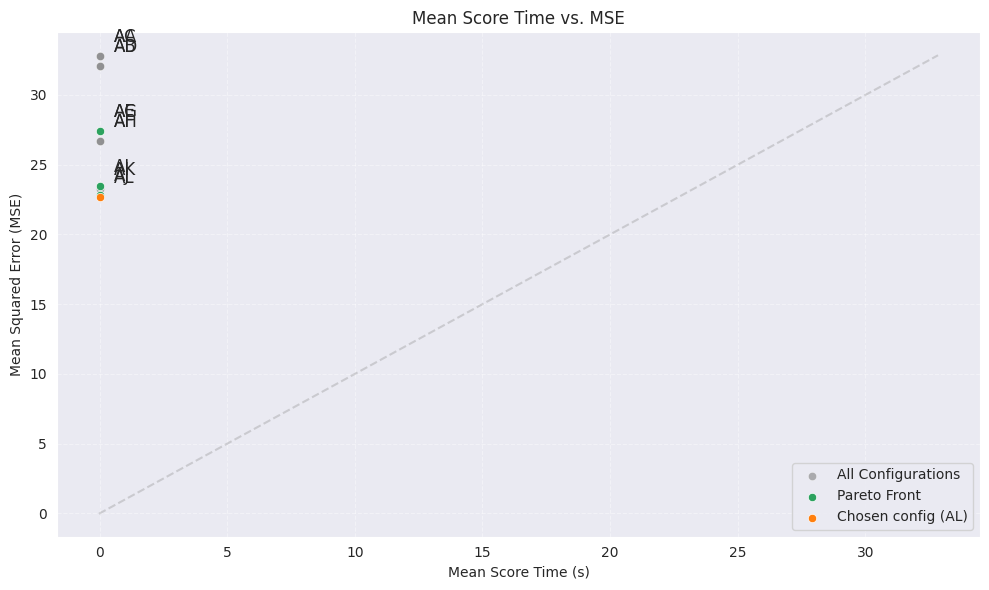

,0
Model,ExtraTreeRegressor
R² Score,0.513668
MSE,22.711766
Max Error,16.924531
Score Time (s),0.005959


Test set evaluation metrics for **ExtraTreeRegressor**


In [19]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

params = {
    "predictor__n_estimators": [2, 3],
    "predictor__min_samples_leaf": [10, 20],
    "predictor__max_depth": [1, 2, 5],
}
et = ExtraTreesRegressor(random_state=seed)
ert_pipeline = create_pipeline(et)

gs = GridSearchCV(ert_pipeline, param_grid=params, cv=5, scoring=scoring, verbose=1, refit=regr_refit_strategy)
gs.fit(X_train, y_train)
print_metrics(gs.cv_results_, gs.best_index_, 'ExtraTreeRegressor')

Fitting 5 folds for each of 24 candidates, totalling 120 fits


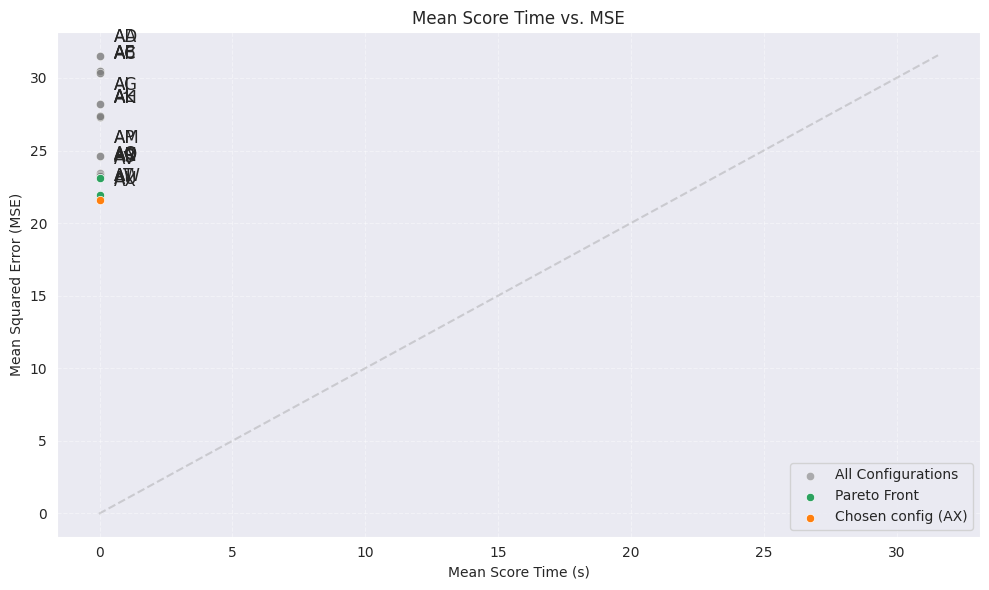

,0
Model,RandomForestRegressor
R² Score,0.536725
MSE,21.595342
Max Error,17.214157
Score Time (s),0.003983


Test set evaluation metrics for **RandomForestRegressor**


In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

params = {
    "predictor__n_estimators": [1, 2, 3],
    "predictor__min_samples_leaf": [10, 20],
    "predictor__max_depth": [1, 2, 3, 5],
}
rfr = RandomForestRegressor(random_state=seed)
rfr_pipeline = create_pipeline(rfr)

gs = GridSearchCV(rfr_pipeline, param_grid=params, cv=5, scoring=scoring, verbose=1, refit=regr_refit_strategy)
gs.fit(X_train, y_train)
print_metrics(gs.cv_results_, gs.best_index_, 'RandomForestRegressor')

## Single decision tree regressor

Fitting 5 folds for each of 9 candidates, totalling 45 fits


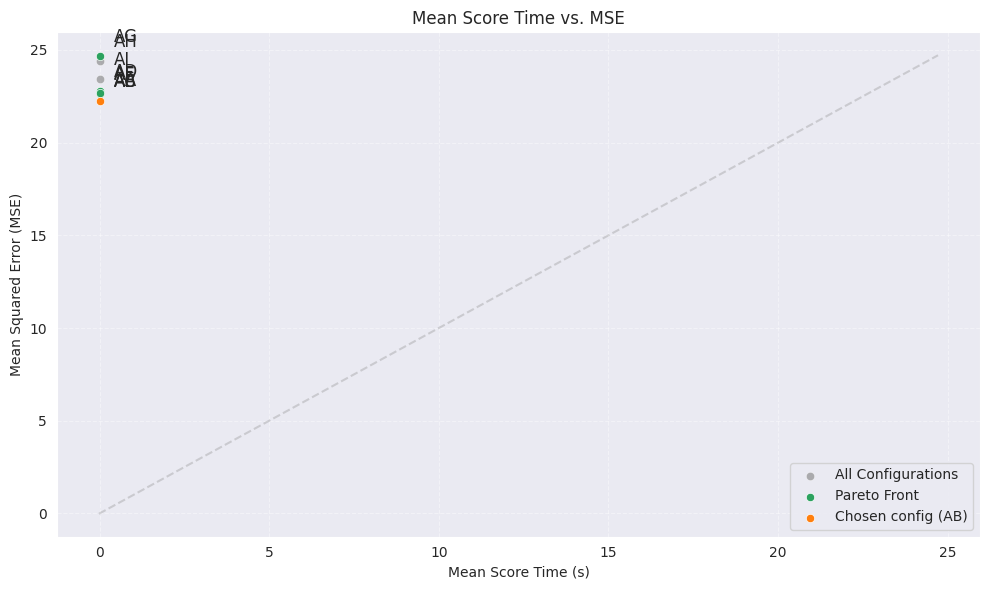

,0
Model,DecisionTreeRegressor
R² Score,0.523213
MSE,22.242827
Max Error,17.582718
Score Time (s),0.003402


Test set evaluation metrics for **DecisionTreeRegressor**


In [21]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

params = {
    "predictor__min_samples_leaf": [5, 7, 10],
    "predictor__max_depth": [5, 7, 10],
}

dt = DecisionTreeRegressor(random_state=seed)
dt_pipeline = create_pipeline(dt)

gs = GridSearchCV(dt_pipeline, param_grid=params, cv=5, scoring=scoring, verbose=1, refit=regr_refit_strategy)
gs.fit(X_train, y_train)
print_metrics(gs.cv_results_, gs.best_index_, 'DecisionTreeRegressor')

Fitting 5 folds for each of 6 candidates, totalling 30 fits


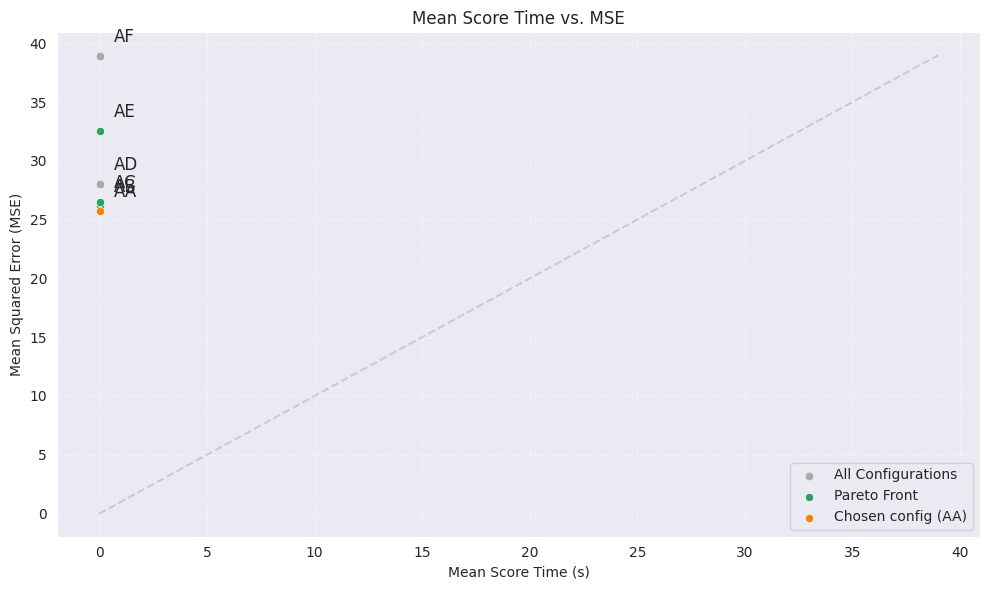

,0
Model,Lasso
R² Score,0.449207
MSE,25.697494
Max Error,16.154333
Score Time (s),0.003322


Test set evaluation metrics for **Lasso**


In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

params = {
    'predictor__alpha': [0.05, 0.3, 0.5, 1, 2, 3]
}

lasso_pipeline = create_pipeline(Lasso(random_state=seed))
gs = GridSearchCV(lasso_pipeline, param_grid=params, cv=5, scoring=scoring, verbose=1, refit=regr_refit_strategy)
gs.fit(X_train, y_train)
print_metrics(gs.cv_results_, gs.best_index_, 'Lasso')

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

lr_pipeline = create_pipeline(LinearRegression())
scores = cross_validate(lr_pipeline, X_train, y_train, cv=5, scoring=scoring)
new_row_data = {
    'Model': 'LinearRegression',
    'R² Score': np.mean(scores['test_r2']),
    'MSE': -np.mean(scores['test_neg_mean_squared_error']),
    'Max Error': -np.mean(scores['test_neg_max_error']),
    'Score Time (s)': np.mean(scores['fit_time'])
}

new_row_df = pd.DataFrame([new_row_data])
display(new_row_df.T)
metrics = pd.concat([metrics, new_row_df], ignore_index=True)

,0
Model,LinearRegression
R² Score,0.468935
MSE,24.774966
Max Error,16.369152
Score Time (s),0.012417


# imodels rules

In [24]:
!pip install imodels


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


Fitting 5 folds for each of 18 candidates, totalling 90 fits


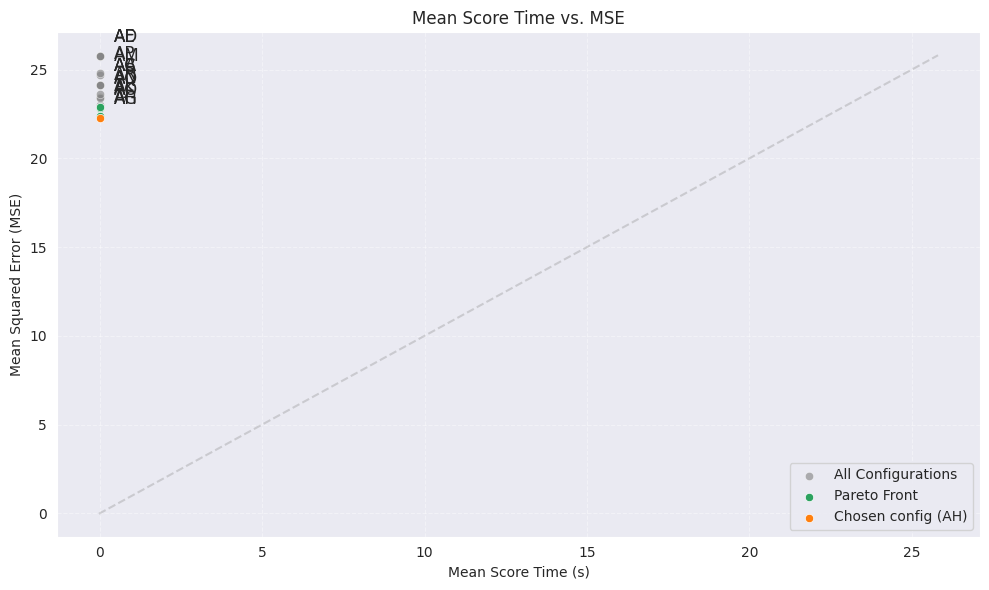

,0
Model,GreedyTreeRegressor
R² Score,0.523033
MSE,22.25027
Max Error,17.582718
Score Time (s),0.003284


Test set evaluation metrics for **GreedyTreeRegressor**


In [25]:
from imodels import GreedyTreeRegressor

params = {
    'predictor__min_samples_leaf': [5, 10, 20],
    'predictor__max_depth': [3, 5, 10],
    'predictor__max_features': [None, 'sqrt']
}

gtr_pipeline = create_pipeline(GreedyTreeRegressor(random_state=seed))
gs = GridSearchCV(gtr_pipeline, param_grid=params, cv=5, scoring=scoring, verbose=1, refit=regr_refit_strategy)
gs.fit(X_train, y_train)
print_metrics(gs.cv_results_, gs.best_index_, 'GreedyTreeRegressor')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


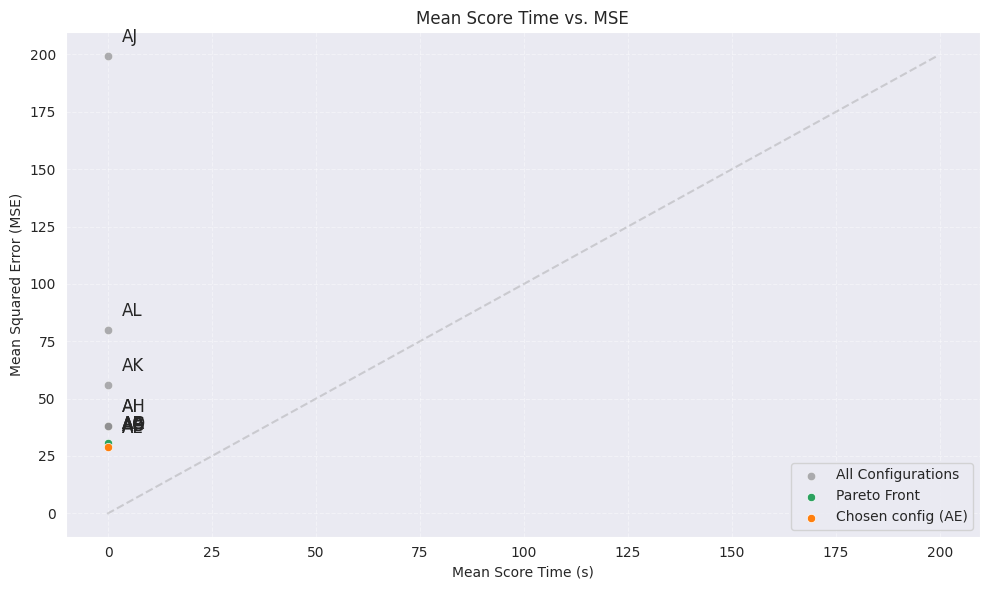

,0
Model,BoostedRulesRegressor
R² Score,0.380027
MSE,28.956394
Max Error,16.781995
Score Time (s),0.003996


Test set evaluation metrics for **BoostedRulesRegressor**


In [26]:
from imodels import BoostedRulesRegressor

params = {
    'predictor__learning_rate': [0.5, 1, 5, 8],
    'predictor__n_estimators': [2, 5, 7]
}

brr_pipeline = create_pipeline(BoostedRulesRegressor(random_state=seed))
gs = GridSearchCV(brr_pipeline, param_grid=params, cv=5, scoring=scoring, verbose=1, refit=regr_refit_strategy)
gs.fit(X_train, y_train)
print_metrics(gs.cv_results_, gs.best_index_, 'BoostedRulesRegressor')

In [27]:
!pip install lightgbm


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/el

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2176
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start training from score -13.064024
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2174
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start training from score -13.938344
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1939
[LightGBM] [Info] Number of data points in the train set:

/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1927
[LightGBM] [Info] Number of data points in the train set: 5928, number of used features: 10
[LightGBM] [Info] Start training from score -13.557979
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2176
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start training from score -13.064024
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2174
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start tr

/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/el

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2165
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start training from score -14.076930


/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1927
[LightGBM] [Info] Number of data points in the train set: 5928, number of used features: 10
[LightGBM] [Info] Start training from score -13.557979
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2176
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start training from score -13.064024
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2174
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start tr

/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/el

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2174
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start training from score -13.938344


/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1939
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start training from score -14.254504
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2165
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start training from score -14.076930
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1927
[LightGBM] [Info] Number of data points in the train set: 5928, number of used features: 10
[LightGBM] [Info] Start tr

/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/el

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1927
[LightGBM] [Info] Number of data points in the train set: 5928, number of used features: 10
[LightGBM] [Info] Start training from score -13.557979


/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2176
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start training from score -13.064024
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2174
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start training from score -13.938344
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1939
[LightGBM] [Info] Number of data points in the train s

/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/el

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1927
[LightGBM] [Info] Number of data points in the train set: 5928, number of used features: 10
[LightGBM] [Info] Start training from score -13.557979
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2176
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start training from score -13.064024
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2174
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start tr

/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/el

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2165
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start training from score -14.076930
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1927
[LightGBM] [Info] Number of data points in the train set: 5928, number of used features: 10
[LightGBM] [Info] Start training from score -13.557979
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2176
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start tr

/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/el

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2176
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start training from score -13.064024
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2174
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start training from score -13.938344
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1939
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start tr

/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2165
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start training from score -14.076930
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1927
[LightGBM] [Info] Number of data points in the train set: 5928, number of used features: 10
[LightGBM] [Info] Start training from score -13.557979
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2176
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start tr

/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/el

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1927
[LightGBM] [Info] Number of data points in the train set: 5928, number of used features: 10
[LightGBM] [Info] Start training from score -13.557979
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2176
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start training from score -13.064024
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2174
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start tr

/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1939
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start training from score -14.254504
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2165
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start training from score -14.076930
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1927
[LightGBM] [Info] Number of data points in the train set: 5928, number of used features: 10
[LightGBM] [Info] Start tr

/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/el

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1939
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start training from score -14.254504
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2165
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start training from score -14.076930
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1927
[LightGBM] [Info] Number of data points in the train s

/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2176
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start training from score -13.064024
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2174
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start training from score -13.938344
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1939
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start tr

/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/el

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1927
[LightGBM] [Info] Number of data points in the train set: 5928, number of used features: 10
[LightGBM] [Info] Start training from score -13.557979
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2176
[LightGBM] [Info] Number of data points in the train set: 5927, number of used features: 10
[LightGBM] [Info] Start training from score -13.064024
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2174
[LightGBM] [Info] Number of data points in the train s

/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1927
[LightGBM] [Info] Number of data points in the train set: 5928, number of used features: 10
[LightGBM] [Info] Start training from score -13.557979


/home/elena/Documents/projects/bnb-branching-strategy-learning/.venv/lib64/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


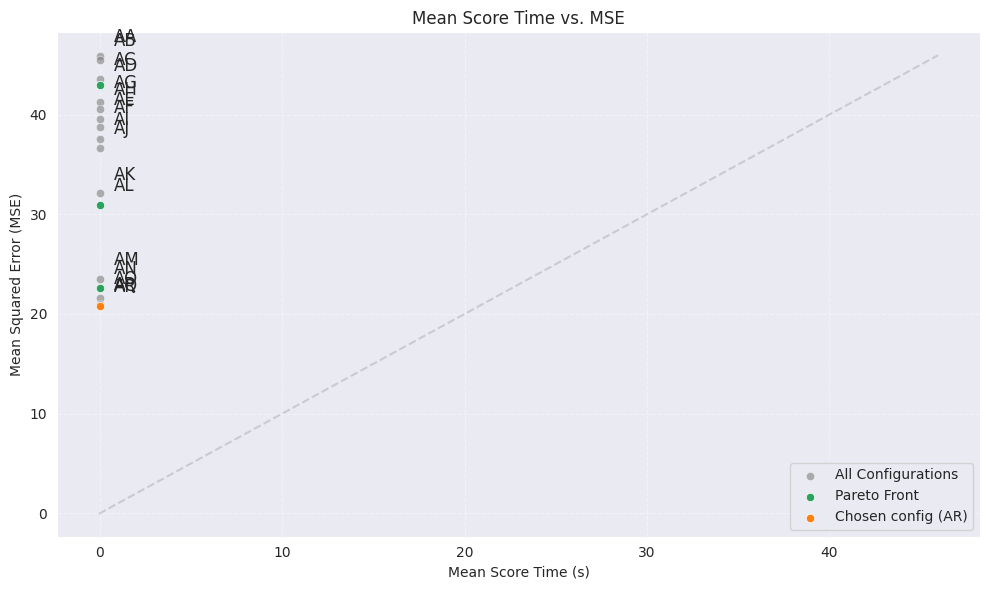

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2211
[LightGBM] [Info] Number of data points in the train set: 7409, number of used features: 10
[LightGBM] [Info] Start training from score -13.778349


,0
Model,LGBMRegressor
R² Score,0.55427
MSE,20.79706
Max Error,17.231231
Score Time (s),0.00502


Test set evaluation metrics for **LGBMRegressor**


In [28]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

params = {
    'predictor__n_estimators': [2, 3, 5],
    'predictor__learning_rate': [0.05, 0.1, 0.5],
    'predictor__num_leaves': [10, 31]
}

lgbm_pipeline = create_pipeline(lgb.LGBMRegressor(random_state=seed, objective='regression', metric='mse', verbose=1))
gs = GridSearchCV(lgbm_pipeline, param_grid=params, cv=5, scoring=scoring, verbose=1, refit=regr_refit_strategy)
gs.fit(X_train, y_train)
print_metrics(gs.cv_results_, gs.best_index_, 'LGBMRegressor')

,Model,R² Score,MSE,Max Error,Score Time (s)
0,ExtraTreeRegressor,0.513668,22.711766,16.924531,0.005959
1,RandomForestRegressor,0.536725,21.595342,17.214157,0.003983
2,DecisionTreeRegressor,0.523213,22.242827,17.582718,0.003402
3,Lasso,0.449207,25.697494,16.154333,0.003322
4,LinearRegression,0.468935,24.774966,16.369152,0.012417
5,GreedyTreeRegressor,0.523033,22.250270,17.582718,0.003284
6,BoostedRulesRegressor,0.380027,28.956394,16.781995,0.003996
7,LGBMRegressor,0.554270,20.797060,17.231231,0.005020


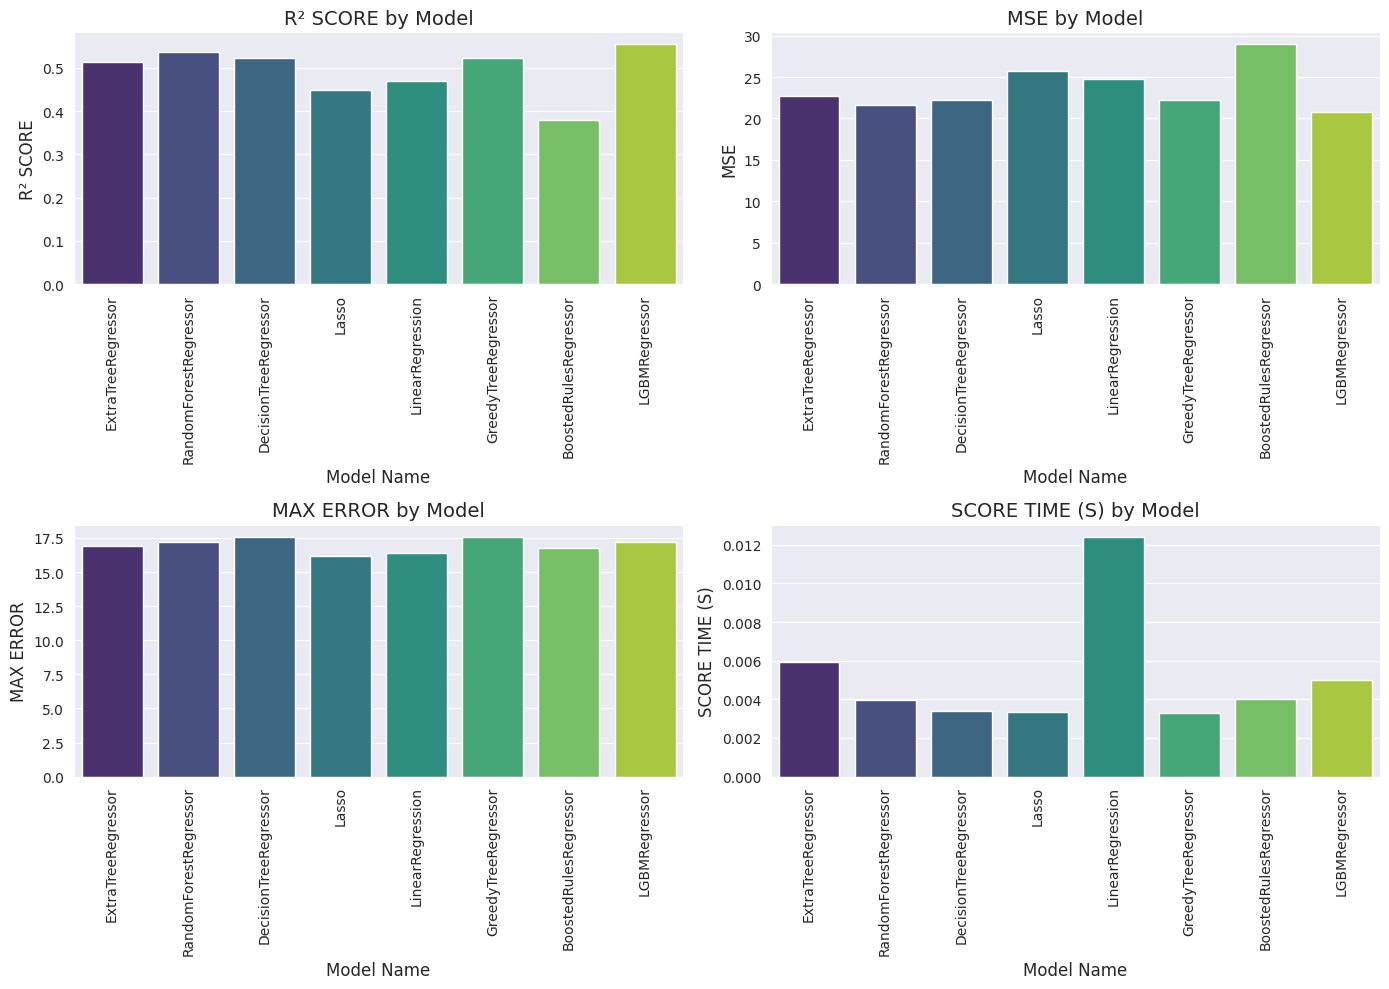

In [29]:
display(metrics)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

#all metrics except name
for i, metric in enumerate(metrics.columns[1:]):
    sns.barplot(x='Model', y=metric, data=metrics, ax=axes[i], palette='viridis')
    axes[i].set_title(f'{metric.upper()} by Model', fontsize=14)
    axes[i].set_xlabel('Model Name', fontsize=12)
    axes[i].set_ylabel(metric.upper(), fontsize=12)
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

## RIPPER

In [30]:
!pip install wittgenstein


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [31]:
import wittgenstein as lw
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from datetime import datetime

params = {
    'predictor__es__k': [1, 2, 3],
    'predictor__es__prune_size': [0.15, 0.33, 0.5],
    'predictor__es__max_rules': [3, 5, 8, 10, 15],
}

discretizer = ('discretizer', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile'))
ripper_pipeline = create_pipeline(OneVsRestClassifier(lw.RIPPER(random_state=seed, n_discretize_bins=None)), additional_pre_steps=[discretizer])

gs = GridSearchCV(ripper_pipeline, param_grid=params, cv=5, scoring='accuracy', verbose=1, refit=regr_refit_strategy)
gs.fit(X_train, y_train)
print(gs.cv_results_)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


ValueError: Invalid parameter 'es' for estimator OneVsRestClassifier(estimator=<RIPPER(random_state=0, n_discretize_bins=None, verbosity=0, prune_size=0.33, max_rule_conds=None, max_rules=None, k=2, dl_allowance=64, max_total_conds=None, alpha=1.0)>). Valid parameters are: ['estimator', 'n_jobs', 'verbose'].

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test_encoded, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Cross Validation')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
from pyscipopt import Model, Branchrule
from pyscipopt import SCIP_RESULT
import numpy as np
from collections import defaultdict
import pandas as pd
import math

class LearnedStrongBranching(Branchrule):
    def __init__(self, model, predictor, A, b, c, logged, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model: Model = model
        self.predictor = predictor
        self.A = A
        self.b = b
        self.c = c
        self.logged = logged
        self.n_branches_by_var = defaultdict(int)
        self.objective_increases_by_var = defaultdict(list)

    def branchexeclp(self, allowaddcons):
        branch_cands, branch_cand_sols, branch_cand_fracs, ncands, npriocands, nimplcands = self.model.getLPBranchCands()

        best_cand_idx = 0
        best_cand_score = float('-inf')
        lpobjval = self.model.getLPObjVal()

        for i in range(npriocands):
          self.n_branches_by_var[branch_cands[i].name] += 1
          var = branch_cands[i]
          down_gain = self.estimate_down_gain(var, lpobjval)
          up_gain = self.estimate_up_gain(var, lpobjval)
          score = self.predictor.predict_score(branch_cand_fracs[i], branch_cands[i].name, down_gain, up_gain)
          if score > best_cand_score:
            best_cand_score = score
            best_cand_idx = i

        self.model.branchVarVal(branch_cands[best_cand_idx], branch_cand_sols[best_cand_idx])
        return {"result": SCIP_RESULT.BRANCHED}

    def estimate_down_gain(self, var, curr_obj):
      estimate = self.model.calcChildEstimate(var, math.floor(var))
      return max([estimate - curr_obj, 0])

    def estimate_up_gain(self, var, curr_obj):
      estimate = self.model.calcChildEstimate(var, math.ceil(var))
      return max([estimate - curr_obj, 0])

    def predict_score(self, frac, var, down_gain, up_gain):
        features = self.extract_feats(frac, var, down_gain, up_gain)
        features = pd.DataFrame([features])
        return self.predictor.predict(pd.DataFrame(features))

    def extract_feats(self, frac, var, down_gain, up_gain):
      params = Params(
          var_idx=var.getCol().getLPPos(),
          x_i=var.getObj(),
          node_depth=self.model.getCurrentNode().getDepth(),
          nr_variables=self.model.getNVars(),
          curr_obj=self.model.getLPObjVal(),
          n_branches_by_var=self.n_branches_by_var[var.name],
          n_nodes=self.model.getNNodes(),
          upfrac=1 - frac,
          downfrac=frac,
          objective_increases=self.objective_increases_by_var[var.name]
      )
      return compute_features(params, self.A, self.b, self.c)
